# Walmart Sales Prediction

Hello!! Here I'll exercise my LSTM skills trying to predict the arrivals for a fictional company orders. The selected dataset provides a comprehensive view of the company's order and distribution processes.

For this purpose, i'll be using Kaggles US_Regional_Sales_Data dataset, which can be found in the following [link](https://www.kaggle.com/datasets/dorothyjoel/us-regional-sales). I'll start with some exploratory analysis and then proceed to build and train my model. The last step will be to evaluate it's capabilities to predict results.

I'll be using the pytorch library for this analysis.

Hope you'll enjoy it.

## 1. Importing Libraries

In [46]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandasql import sqldf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 


# 2. Importing Dataset

Here i'll import the dataset that we'll be working with. This dataset provides a comprehensive view of the company's order and distribution processes and will allow us to make our predictive analysis.

In [47]:
df = pd.read_csv('US_Regional_Sales_Data.csv',encoding='unicode_escape', sep=',', header=0)

display(df.head())

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.08,"$1,001.18","$1,963.10"
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/2018,USD,14,20,196,27,3,0.08,"$3,348.66","$3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/2018,USD,21,16,213,16,1,0.05,$781.22,"$1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/2018,7/6/2018,USD,28,48,107,23,8,0.08,"$1,464.69","$2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,10/4/2018,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.10,"$1,476.14","$1,822.40"


# 3. Data Cleansing and Treatment

Here i'll treat the data so I can get only the usefull info into my model.


Here we can see gathered info that will be used in this analysis.


,_SalesTeamID,_StoreID,_ProductID,Order_Qty
corrected_date,,,,
2019-02-01,17,258,44,39
2019-03-01,18,214,3,41
2019-04-01,2,320,30,18
2019-05-01,8,351,14,50
2019-06-01,19,284,23,49
...,...,...,...,...
2019-05-09,21,137,1,55
2019-06-09,28,181,18,43
2019-07-09,18,117,3,17



Here we can see a historical plot of all sales qty.


Text(0.5, 0, 'Time')

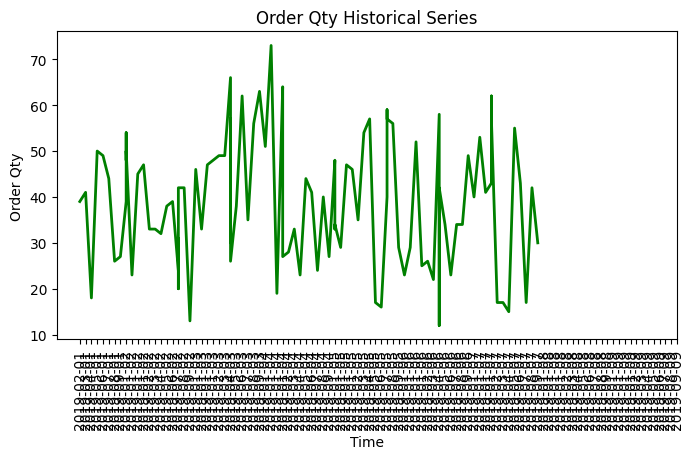

In [48]:
df_delivered_qty = sqldf('''


SELECT DeliveryDate,  df.'_SalesTeamID',_StoreID
                         , _ProductID,
                
        '20'||substr(DeliveryDate, -2)||'-'||
        
        CASE WHEN length(substr(DeliveryDate,INSTR(DeliveryDate,'/')+1,3))=2 then  substr(DeliveryDate,3,1) else '0'||substr(DeliveryDate,3,1) end ||'-'||
        CASE WHEN length(substr(DeliveryDate, INSTR(DeliveryDate,'/')+1,2)) = 1 then substr(DeliveryDate,1,2) ELSE '0'||substr(DeliveryDate,1,1) END
        as corrected_date,

        SUM(df.'Order Quantity') as Order_Qty


                        FROM df 
                        
                        where JULIANDAY(corrected_date)  < JULIANDAY(DATE('2020-01-01'))
                        
                        and  JULIANDAY(corrected_date)  > JULIANDAY(DATE('2019-01-01'))
                        
                        GROUP BY DeliveryDate
                        
                        ORDER BY DeliveryDate ASC

''')


print('\nHere we can see gathered info that will be used in this analysis.')


df_delivered_qty.drop(['DeliveryDate'], axis='columns', inplace=True)
df_delivered_qty.set_index('corrected_date', inplace=True)
display(df_delivered_qty)


print('\nHere we can see a historical plot of all sales qty.')

x = np.arange(len(df_delivered_qty['Order_Qty']))

fig, ax = plt.subplots(figsize=(8,4))


ax.plot(df_delivered_qty['Order_Qty'],color='green',linewidth=2)
ax.set_xticks(x)
ax.set_xticklabels(df_delivered_qty.index.values, rotation = 'vertical')
ax.set_title('Order Qty Historical Series')
ax.set_ylabel('Order Qty')
ax.set_xlabel('Time')


Now that I have the date, i'll divide into the independent and dependent variables (x and y, respectively.)

In [49]:
x= df_delivered_qty.iloc[:, :-1]
y= df_delivered_qty['Order_Qty']

y=y.values.reshape(-1,1)

display(x)

,_SalesTeamID,_StoreID,_ProductID
corrected_date,,,
2019-02-01,17,258,44
2019-03-01,18,214,3
2019-04-01,2,320,30
2019-05-01,8,351,14
2019-06-01,19,284,23
...,...,...,...
2019-05-09,21,137,1
2019-06-09,28,181,18
2019-07-09,18,117,3


In order to get a better result, i'll normalize my data.

In [50]:

mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(x)
y_mm = mm.fit_transform(y) 

Now i'll divide the data into training and testing sets.

In [51]:
#first 100 for training
n= 100
X_train = X_ss[:n, :]
X_test = X_ss[n:, :]

y_train = y_mm[:n, :]
y_test = y_mm[n:, :] 

In [52]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (100, 3) (100, 1)
Testing Shape (4, 3) (4, 1)


Converting data to torch tensors.

In [53]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

Now reshaping those tensors...

In [54]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [55]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([100, 1, 3]) torch.Size([100, 1])
Testing Shape torch.Size([4, 1, 3]) torch.Size([4, 1])


Now that we have our training and test sets defined, we can define and train our LSTM model.

In [56]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

Defining our model main parameters...

In [57]:

num_epochs = 5000 #1000 epochs
learning_rate = 0.003 #0.001 lr

input_size = 3 #number of features
hidden_size = 50 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [58]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, 200) #our lstm class

Here i'll define our model criteria for improvement. I'll get the Loss and accuracy for each epoch, so we can see if the model is improving through time.

In [59]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

### Now let's train our model!!!

I'll print the loss for each 100 epochs so we can see our model improving.

In [60]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    
    loss.backward() #calculates the loss of the loss function
    
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.21396


Epoch: 100, loss: 0.04434
Epoch: 200, loss: 0.02496
Epoch: 300, loss: 0.01064
Epoch: 400, loss: 0.00493
Epoch: 500, loss: 0.00248
Epoch: 600, loss: 0.00123
Epoch: 700, loss: 0.00072
Epoch: 800, loss: 0.00035
Epoch: 900, loss: 0.00025
Epoch: 1000, loss: 0.00014
Epoch: 1100, loss: 0.00011
Epoch: 1200, loss: 0.00007
Epoch: 1300, loss: 0.00004
Epoch: 1400, loss: 0.00003
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00004
Epoch: 1700, loss: 0.00075
Epoch: 1800, loss: 0.00000
Epoch: 1900, loss: 0.00001
Epoch: 2000, loss: 0.00000
Epoch: 2100, loss: 0.00000
Epoch: 2200, loss: 0.00000
Epoch: 2300, loss: 0.00000
Epoch: 2400, loss: 0.00000
Epoch: 2500, loss: 0.00000
Epoch: 2600, loss: 0.00000
Epoch: 2700, loss: 0.00000
Epoch: 2800, loss: 0.00000
Epoch: 2900, loss: 0.00000
Epoch: 3000, loss: 0.00000
Epoch: 3100, loss: 0.00000
Epoch: 3200, loss: 0.00000
Epoch: 3300, loss: 0.00000
Epoch: 3400, loss: 0.00000
Epoch: 3500, loss: 0.00000
Epoch: 3600, loss: 0.00000
Epoch: 3700, loss: 0.00001
Epoch: 380

Nice!! Now we have a trained model.


Let's transform our data so we can convert it with our trained model.

In [61]:
df_X_ss = ss.transform(df_delivered_qty.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df_delivered_qty.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

C:\Users\lucas.zannoni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


For last, let's use the data to predict the sales qty and then compare it with the original curve.

Here well print the predicted curve alongside the original one.



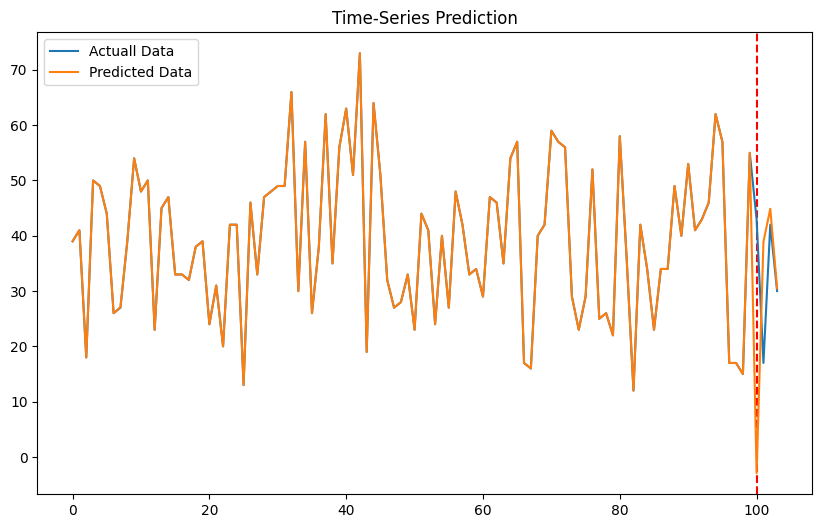

In [63]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()



print('Here we''ll print the predicted curve alongside the original one.\n' )


data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=n, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

We can see that our model does a fairly good job predicting the curve with the train dataset, but can fall astray with the predicted one.

There are some things we can do in order to improve our model.

- Get the RMSE data so we can have a standard measure for the curve deviation.
- Play with our model's constraints in order to reach the best input for the model.
- Change/Add more steps to our Neural Networks, maybe some non-linear activation functions, such as ReLu or Sigmoid.

I'd also have to be careful with these modifications, since they can drastically increase our model's computational cost.

In the end we'd have to analyze which changes would be worth our while.